#Support Vector Machines

**Author:** Karthik Desingu    
**Date:** October 20th, 2022

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Background: The Need for Support Vector Machines

SVMs are known for their ability to perform **discriminative classification**: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

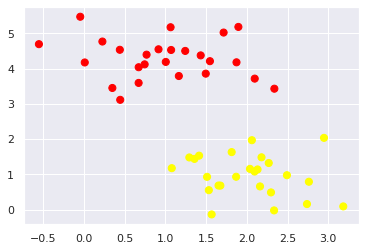

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A **linear discriminative classifier** would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.

Clearly, there is more than one possible dividing line that can perfectly discriminate between the two classes!

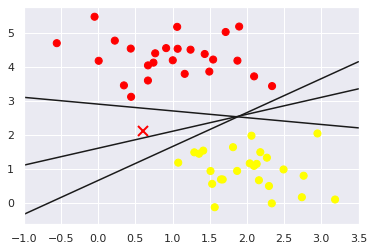

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples. Depending on which line is chosen, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label. That, to a great extent, influences something called **robustness** of the model.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

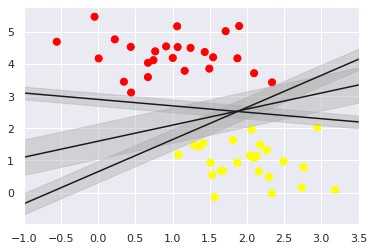

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of a class of such learners, called **maximum margin** estimator.

### Fitting a Support Vector Machine

To implement SVMs practically, it is far more efficient to use a packaged library --- they vectorize implementations, bulky computations by themselves, that would otherwise take forever to run on large datasets.

Here, Scikit-Learn's support vector classifier is used to train an SVM model on this data. Here, a "linear kernel" is used, and the ``C`` parameter is set to a very large number.

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

The following is a quick convenience function that will plot SVM decision boundaries for us, on the fly:
(skip through to focus on the concept)

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

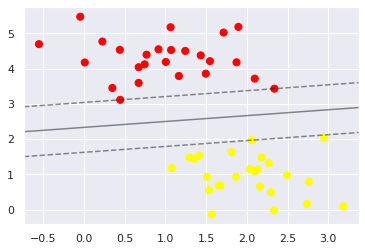

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the **support vectors**, and give the algorithm its name.

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit. This is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin --- that, of course, is a consequence of the simplified **primal form of SVM**.

Practically, however, this is evident from a few sample plots. The model learned from the first 60 points and first 120 points of this dataset is plotted below:

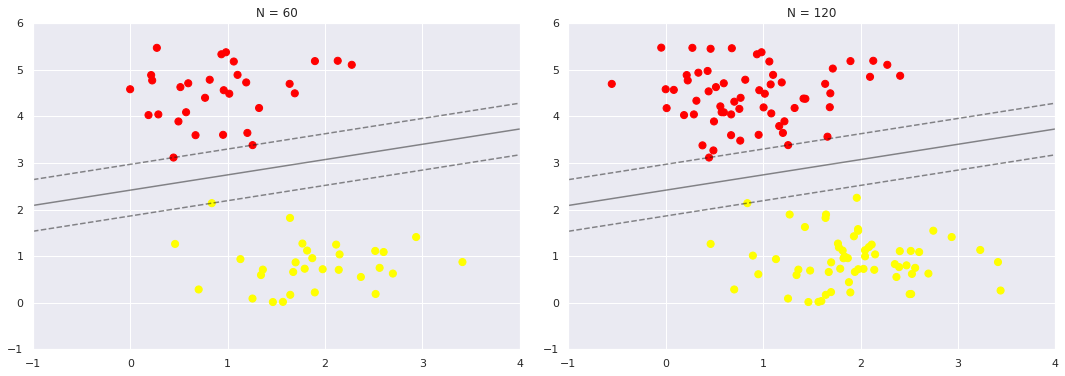

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but **the model has not changed**: the three support vectors from the left panel are still the support vectors from the right panel.

This *insensitivity to the exact behavior of distant points* is one of the strengths of the SVM model.

### Modeling Complex Boundaries: Kernel SVM

SVM becomes extremely powerful when it is combined with functional **kernels** --- mathematical constructs that often represent natural occurrence patterns of data.

It allows data to be **projected into higher-dimensional space** defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

To realized the need for kernels, here's some data that is NOT linearly separable:

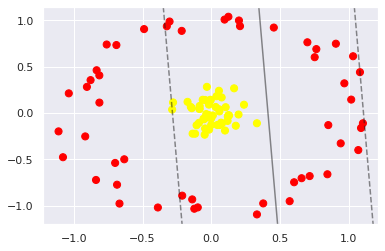

In [10]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data. A straightforward and simple projection we could use to separate the classes of this data would be to compute a **radial basis function** centered at the "clump" in the middle:

In [11]:
r = np.exp(-(X ** 2).sum(1))

This additional data dimension can be visualized using a three-dimensional plot.

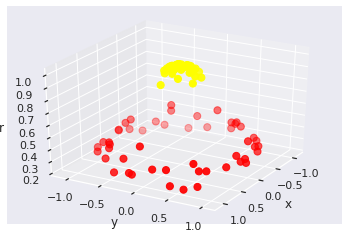

In [12]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D()

Clearly, with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, **r=0.7**.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.

In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use. One strategy to this end is to compute a basis function centered at **every** point in the dataset, and let the SVM algorithm "sift" in through the results. This sort of basis function transformation is known as a **kernel transformation**, as it is based on a similarity relationship between each pair of points.

A natural problem with this strategy though, is that *projecting $N$ points into $N$ dimensions* is very computationally intensive!

####Enter, the [**kernel trick**](https://en.wikipedia.org/wiki/Kernel_trick)!   
A fit on kernel-transformed data can be done implicitly.    
Without ever building the full $N$-dimensional representation of the kernel projection. This kernel trick is built into the SVM, and is one of the reasons the method is so powerful. Again, a mathematical construct that becomes apparent in the multivariate primal form, with Langrangian treatment!

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter --- the same argument that we used with `linear`, earlier.

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

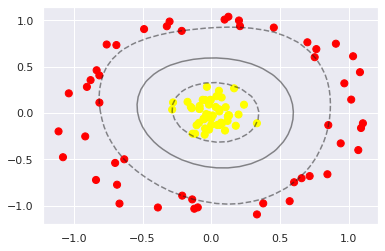

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.

### Tuning the SVM to be more "forgiving!": Soft Margin Classification

Our discussion thus far has centered around very clean datasets - ones we generated using noisy mathematical functions - in which a perfect decision boundary exists. 

But real-time data is seldom that simple, typically characterized by a significant degree of overlap? Here's an example:

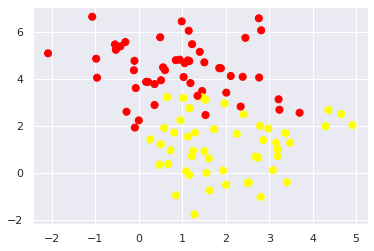

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation introduces a bit of a "leeway" which "softens" the margin: it **allows some of the points to migrate into the margin**, provided that that allows a better fit. The hardness of the margin is controlled by a **penalty parameter**, most often denoted as $C$. For very **large $C$**, the **margin is hard**, and points cannot lie in it. For **smaller $C$**, the **margin is softer**, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, by softening the margin.

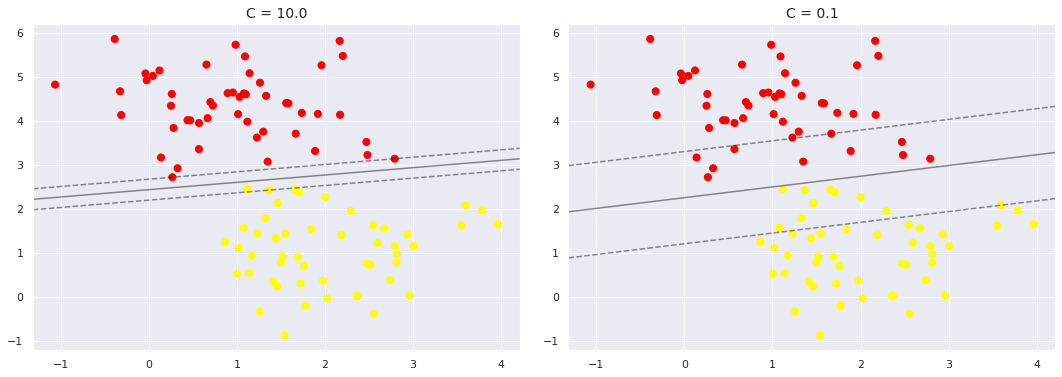

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or other typical hyperparameter tuning procedures.

## A Real Dataset: Face Recognition

In subsequent cells, we employ support vector machines for the facial recognition problem. We use the [**Labeled Faces in the Wild dataset**](http://vis-www.cs.umass.edu/lfw/), which consists of several thousand collated photos of various public figures. 

We first fetch this data:

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


And here's a set of sampes from the dataset,

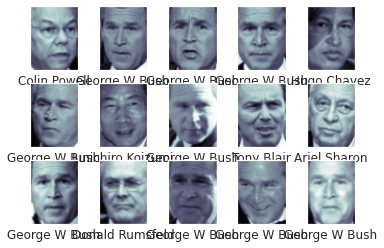

In [18]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image is $62 \times 47$. 

We could proceed by simply using each pixel value as a feature --- exactly what we do in a Neural Network, but for a traditional learner like the SVM, it would be more effective to use some sort of **preprocessor to extract more meaningful features**.

We use Principal Component Analysis (PCA) to extract **150 high-variance-yielding components** to feed into our support vector machine classifier.

In [19]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Split the data into train and test sets.

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

As mentioned already, the hyperparameters, ``C`` and ``gamma`` here, can be searched for optimal values using any approach. Here, we used **grid search** cross-validation to explore effective combinations of values for these parameters.

Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model,

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 49 s, sys: 17.2 s, total: 1min 6s
Wall time: 36.1 s
{'svc__C': 10, 'svc__gamma': 0.001}


Now with this cross-validated model, we can predict the labels for the test data, to truly evaluate the effectiveness of the model.

In [22]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

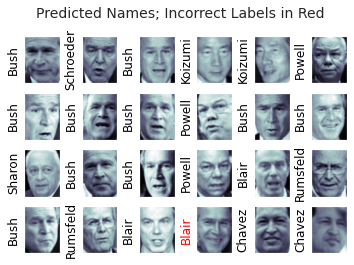

In [23]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

To get a quantitative measure of the model's performance, the following cell generates a classification report, listing the usual measures per class label.

In [24]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



...and a confusion matrix,

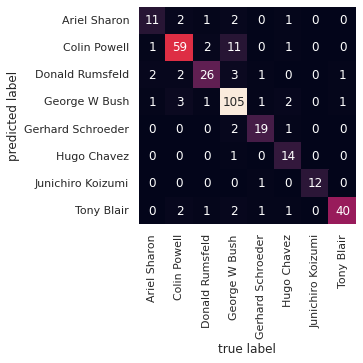

In [25]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids. Further, a more effective facial classification scheme would need better **feature selection**: a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.

## Support Vector Machine Summary

This presentation lead through a brief intuitive introduction to the principals behind support vector machines. These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

**Author:** Karthik Desingu    
**Date:** October 20th, 2022

## Saving the Notebook

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [33]:
!ls
import os
os.chdir("/content/drive/MyDrive/Undergrad/Presentations")
!jupyter nbconvert --to PDF "Support-Vector-Machines_Karthik-Desingu.ipynb"

drive  sample_data
[NbConvertApp] Converting notebook Support-Vector-Machines_Karthik-Desingu.ipynb to PDF
[NbConvertApp] Support files will be in Support-Vector-Machines_Karthik-Desingu_files/
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbConvertApp] Making directory ./Support-Vector-Machines_Karthik-Desingu_files
[NbCon